In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout , Conv1D, MaxPooling1D, Flatten, Input, concatenate


warnings.filterwarnings("ignore")

In [3]:
# --- 1. Load and Prepare Data ---
# Define the file path
file_path = '/content/drive/MyDrive/Reviews.csv'

df = pd.read_csv(file_path)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [5]:
df.shape

(568454, 10)

In [6]:
# Drop specified columns
columns_to_drop = ['ProductId', 'Id', 'ProfileName', 'UserId', 'HelpfulnessDenominator', 'HelpfulnessNumerator', 'Time']
df.drop(columns=columns_to_drop, inplace=True)


In [7]:
# Verify the columns are dropped
df.head()

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [9]:
# Combine 'summary' and 'text' into a single feature, ensuring all text is properly handled
df['Summary'] = df['Summary'].fillna('').astype(str)
df['Text'] = df['Text'].fillna('').astype(str)
df['Combined_text'] = df['Summary'] + " " + df['Text']

In [10]:
# --- 2. Preprocess Text Data ---
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['Combined_text'])
sequences = tokenizer.texts_to_sequences(df['Combined_text'])
word_index = tokenizer.word_index

In [11]:
# Pad sequences to ensure uniform input size
max_length = 300
data = pad_sequences(sequences, maxlen=max_length)
data.shape

(568454, 300)

In [12]:
y_dict = {1:0, 2:0, 3:1, 4:1, 5:1}
y = df['Score'].map(y_dict)
y

0         1
1         0
2         1
3         0
4         1
         ..
568449    1
568450    0
568451    1
568452    1
568453    1
Name: Score, Length: 568454, dtype: int64

In [13]:
# --- 3. Handle Class Imbalance and Encode Labels ---
df['Score'] = df['Score'].fillna(df['Score'].mode()[0])
print("Class distribution before oversampling:", Counter(y))

ros = RandomOverSampler(random_state=42)
data_resampled, labels_resampled = ros.fit_resample(data, y)

print("Class distribution after oversampling:", Counter(labels_resampled))

Class distribution before oversampling: Counter({1: 486417, 0: 82037})
Class distribution after oversampling: Counter({1: 486417, 0: 486417})


In [14]:
# Encode labels (after oversampling)
label_encoder = LabelEncoder()
labels_resampled = label_encoder.fit_transform(labels_resampled)
labels_resampled = to_categorical(labels_resampled, num_classes=2)

In [15]:
# --- 4. Train-Test Split ---
x_train, x_val, y_train, y_val = train_test_split(
    data_resampled, labels_resampled, test_size=0.2, random_state=42
)

In [16]:
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

x_train shape: (778267, 300)
x_val shape: (194567, 300)
y_train shape: (778267, 2)
y_val shape: (194567, 2)


In [17]:
# --- 5. Build WDE_LSTM + CNN Model ---

from tensorflow.keras.models import Model


embedding_dim = 128
vocab_size = len(word_index) + 1

# Input layer for the text data
input_text = Input(shape=(max_length,))

# Embedding layer
embedding_layer = Embedding(vocab_size, embedding_dim)(input_text)

# CNN Branch
cnn_branch = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding_layer)
cnn_branch = MaxPooling1D(pool_size=2)(cnn_branch)
cnn_branch = Flatten()(cnn_branch)

# LSTM Branch
lstm_branch = LSTM(units=128)(embedding_layer)

# Concatenate CNN and LSTM outputs
merged = concatenate([cnn_branch, lstm_branch])

# Output layer
output = Dense(2, activation='sigmoid')(merged)

# Create the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 300, 128)             1785740   ['input_1[0][0]']             
                                                          8                                       
                                                                                                  
 conv1d (Conv1D)             (None, 298, 32)              12320     ['embedding[0][0]']           
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 149, 32)              0         ['conv1d[0][0]']          

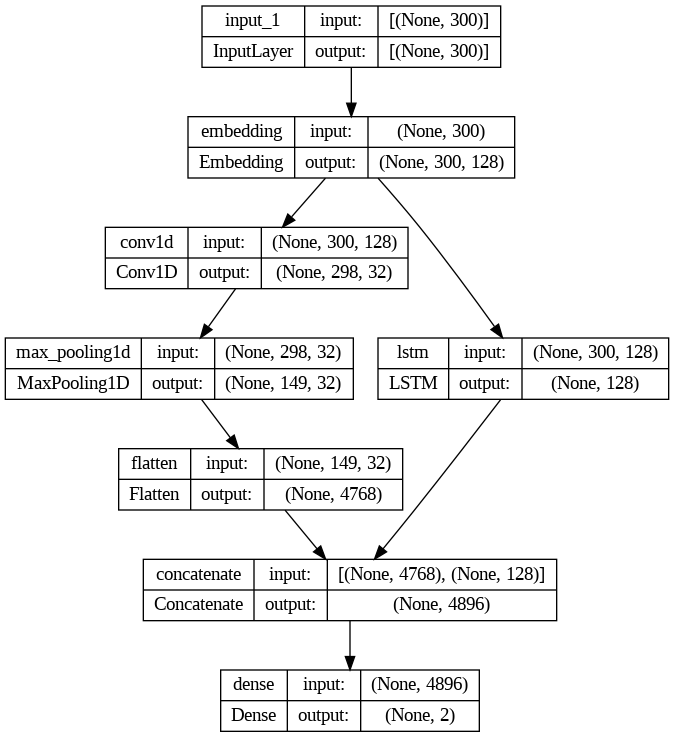

In [19]:
from tensorflow.keras.utils import plot_model

# Assuming your model is already created and named `model`

plot_model(model, to_file="Architecture of Amazon WDE-LSTM + CNN 2 scores.png", show_shapes=True)  # Adjust filename as needed

In [ ]:
# --- 8. Train the Model ---
import time
# Start time measurement
start_time = time.time()

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_val, y_val))

# End time measurement
end_time = time.time()

# Calculate total time
print(f"Total training time: {end_time - start_time:.4f} seconds")

Epoch 1/5
24321/24321 ━━━━━━━━━━━━━━━━━━━━ 596s 24ms/step - accuracy: 0.9167 - loss: 0.2111 - val_accuracy: 0.9671 - val_loss: 0.0998
Epoch 2/5
24321/24321 ━━━━━━━━━━━━━━━━━━━━ 592s 24ms/step - accuracy: 0.9786 - loss: 0.0663 - val_accuracy: 0.9783 - val_loss: 0.0773
Epoch 3/5
24321/24321 ━━━━━━━━━━━━━━━━━━━━ 591s 24ms/step - accuracy: 0.9906 - loss: 0.0300 - val_accuracy: 0.9835 - val_loss: 0.0728
Epoch 4/5
24321/24321 ━━━━━━━━━━━━━━━━━━━━ 591s 24ms/step - accuracy: 0.9947 - loss: 0.0176 - val_accuracy: 0.9819 - val_loss: 0.1044
Epoch 5/5
24321/24321 ━━━━━━━━━━━━━━━━━━━━ 587s 24ms/step - accuracy: 0.9962 - loss: 0.0137 - val_accuracy: 0.9850 - val_loss: 0.1012
Total training time: 2957.4379 seconds


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Validation Accuracy: {accuracy}')

6081/6081 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - accuracy: 0.9847 - loss: 0.1032
Validation Accuracy: 0.9849820137023926


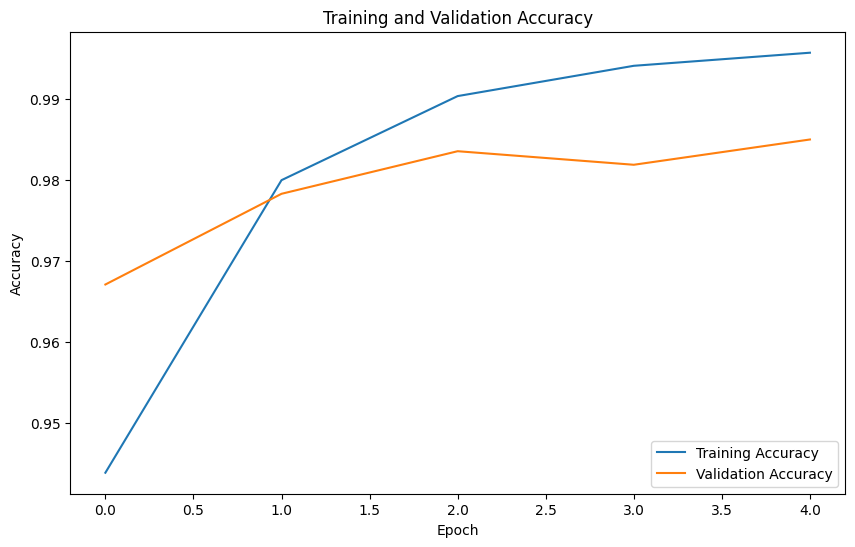

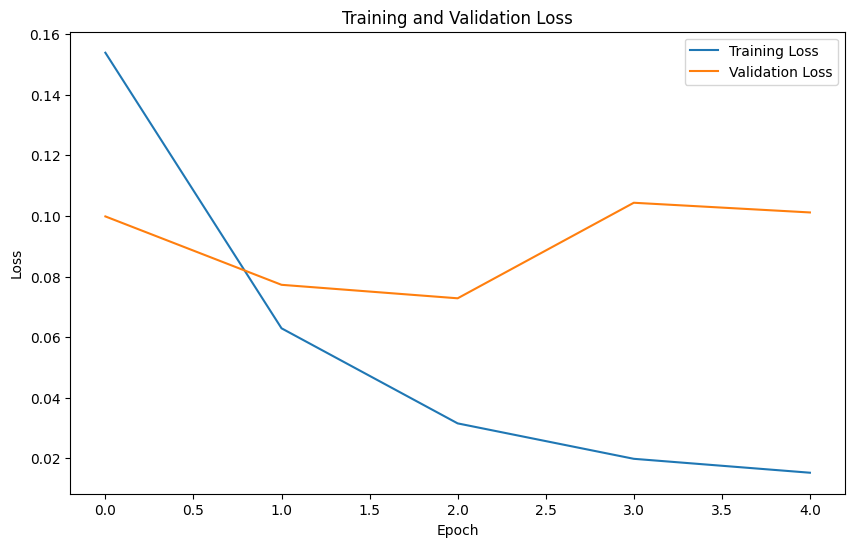

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss
plt.figure(figsize=(10, 6))

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [ ]:
# Example prediction
new_texts = ["This product is excellent.", "Not what I expected."]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_data = pad_sequences(new_sequences, maxlen=max_length)

predictions = model.predict(new_data)
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))
print(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
[1 0]


In [ ]:
# Predict on the validation set
y_val_pred = model.predict(x_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

6081/6081 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
# Calculate metrics
accuracy = accuracy_score(y_val_true, y_val_pred_classes)
precision = precision_score(y_val_true, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true, y_val_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

print("\nClassification Report:\n", classification_report(y_val_true, y_val_pred_classes))



Accuracy: 0.9849820370360852
Precision: 0.9852098849393517
Recall: 0.9849820370360852
F1 Score: 0.9849802882066052

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     97275
           1       1.00      0.97      0.98     97292

    accuracy                           0.98    194567
   macro avg       0.99      0.98      0.98    194567
weighted avg       0.99      0.98      0.98    194567



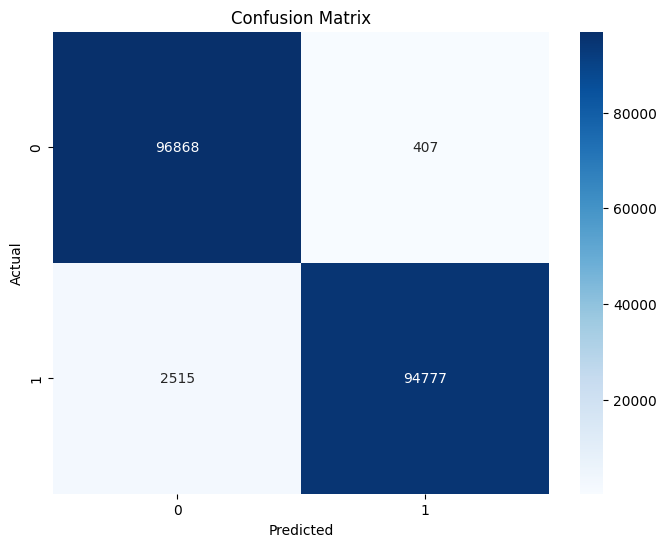

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import tensorflow as tf
import keras as ks
print(tf.__version__)
print(ks.__version__)

2.15.0
3.3.3
